<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-setup-functions" data-toc-modified-id="Imports-and-setup-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and setup functions</a></span></li><li><span><a href="#Read-netCDF-files" data-toc-modified-id="Read-netCDF-files-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read netCDF files</a></span><ul class="toc-item"><li><span><a href="#Methods" data-toc-modified-id="Methods-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Methods</a></span></li><li><span><a href="#Test:-Read-data-from-2021" data-toc-modified-id="Test:-Read-data-from-2021-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Test: Read data from 2021</a></span></li><li><span><a href="#Get-data-from-masked-array" data-toc-modified-id="Get-data-from-masked-array-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Get data from masked array</a></span><ul class="toc-item"><li><span><a href="#Invalid-values" data-toc-modified-id="Invalid-values-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Invalid values</a></span></li></ul></li></ul></li><li><span><a href="#Reduce-image-size" data-toc-modified-id="Reduce-image-size-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Reduce image size</a></span></li></ul></div>

# Imports and setup functions

In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray

In [2]:
def dataDir(x):
    cwd = os.getcwd()
    
    return cwd + "/data/" + x

# Read netCDF files

## Methods

In [3]:
def create_month_dataset(year_path, exclude=[]):
    
    # |data/
    # |--- |SST_ATL_PHY.../
    # |----|-------------- |2021/
    # |----|---------------|--- |01/
    # |----|---------------|----|- 20210101_image.nc  # (day 1)
    # |----|---------------|----|- 20210102_image.nc  # (day 2)
    # |----|---------------|----|- 20210103_image.nc  # (day 3) ...
    
    dataset = {}
    
    m_paths = [year_path + m for m in os.listdir(year_path)]
    m_paths.sort()
    
    print("Creating dataset from year: " + year_path[-5:-1] + "...")
    
    for m in m_paths:
        
        # Create ID
        m_id = "sst_" + year_path[-5:-1] + "-" + m[-2:]
        
        # Read data into MFDataset
        print("...Month: " + m[-2:] + "...")
        
        m_nc = nc.MFDataset(files=(m + "/*.nc"), aggdim="time", 
                            exclude=exclude)
       
        # Save to dictionary with datasets
        dataset[m_id] = m_nc
        
    return dataset

## Test: Read data from 2021

In [180]:
vars_to_exclude = ["lat", "lon", "sst_dtime", "solar_zenith_angle", 
                   "quality_level", "sses_bias", "sses_standard_deviation", 
                   "or_latitude", "or_longitude", "or_number_of_pixels", 
                   "source_of_sst", "adjusted_sea_surface_temperature",
                   "satellite_zenith_angle", "time"]


test = create_month_dataset(dataDir("SST_ATL_PHY_L3S_NRT_010_037/2021/"),
                            vars_to_exclude)

Creating dataset from year: 2021...
...Month: 01...
...Month: 02...
...Month: 03...
...Month: 04...
...Month: 05...
...Month: 06...
...Month: 07...
...Month: 08...
...Month: 09...
...Month: 10...
...Month: 11...
...Month: 12...


In [82]:
test["sst_2021-06"]["sea_surface_temperature"].shape

(30, 2950, 2000)

In [181]:
test["sst_2021-06"]

<class 'netCDF4._netCDF4.MFDataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.7, ACDD-1.3, ISO 8601
    standard_name_vocabulary: Climate and Forecast (CF) Standard Name Table v79
    naming_authority: org.ghrsst
    netcdf_version_id: 4.7.4 of Oct 31 2021 03:14:43 $
    title: ODYSSEA North-East Atlantic Sea Surface Temperature Gridded Level 3S Daily Multi-Sensor Observations
    id: ODYSSEA-IFR-L3S-ATL_002-v3.0
    cmems_product_id: SST_ATL_PHY_L3S_NRT_010_037
    summary: This dataset provide a times series of daily multi-sensor composite fields of Sea Surface Temperature (SST) foundation at ultra high resolution (UHR) on a 0.02 x 0.02 degree grid (approximately 2 x 2 km) for the North-East Atlantic (European North West shelf, Iberia, Bay of Biscay, Irish Sea down to Canary upwelling), every 24 hours. It is produced for the Copernicus Marine Service.
    references: Product User Manual for L3S Odyssea Product over the North-West Shelf-Irish-Bi

## Get data from masked array 

In [83]:
test_sst_ma = test["sst_2021-06"]["sea_surface_temperature"][0,] # just June
print(type(test_sst_ma))
print(test_sst_ma.shape)

<class 'numpy.ma.core.MaskedArray'>
(2950, 2000)


In [86]:
# Computations on masked arrays don't use the masked (invalid) values

print(test_sst_ma.mean())  
print(test_sst_ma.data.mean())

288.92737490621766
-25061.09674607625


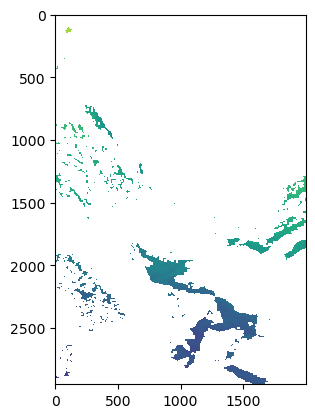

In [87]:
plt.imshow(test_sst_ma)

### Invalid values

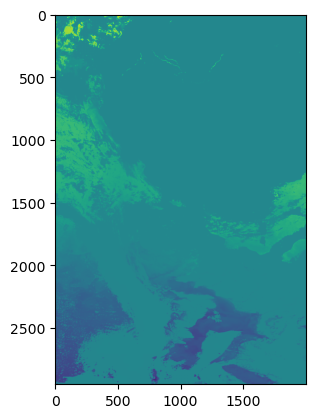

In [91]:
test_sst_filled = test_sst_ma.filled(test_sst_ma.mean())  # fill with mean
plt.imshow(test_sst_filled)

In [260]:
def get_valid_slices_ma(data, threshold=0.5, window_size=256, step=100):
    
    candidates = []
    m = data.shape[0]
    n = data.shape[1]
    
    row = 0
    col = 0
    
    while row < m:
        while col < n:
            
            cand = data[row:row+window_size, col:col+window_size]
            
            if (cand.mask.sum() <= threshold*(window_size**2)) & (cand.shape == (256,256)):
                candidates.append(cand)
                #print(cand.shape)
                #print(type(cand))
                
            col += step
        
        row += step
        col = 0
    
    #for i in range(m+1):
        # cand = data[i:window_size+i]
        # cand = data[i:i+window_size,:].reshape((-1,1))
        
        #if cand.mask.sum() <= invalid_threshold*(window_size**2):        
            #candidates.append(np.expand_dims(cand, 0))
            #print(cand.shape)
            
        #else:
            #pass
    
    return np.ma.masked_array(candidates) #np.vstack(candidates)

In [264]:
test_slices = get_valid_slices_ma(test_sst_ma, threshold=0.1, step=100) # threshold=0.25
print(test_slices.shape)
print(type(test_slices))

(7, 256, 256)
<class 'numpy.ma.core.MaskedArray'>


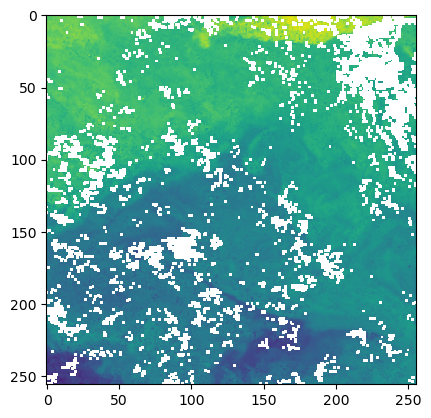

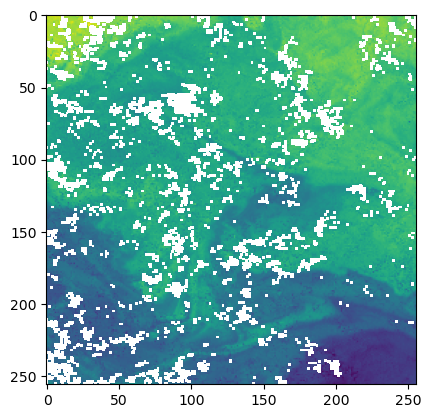

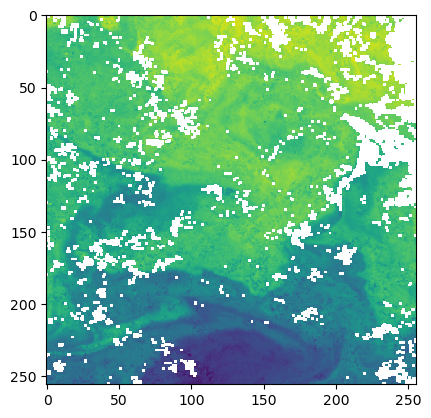

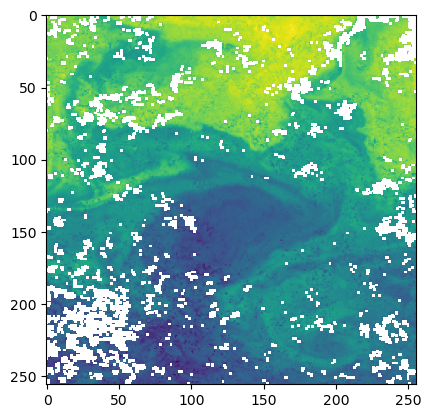

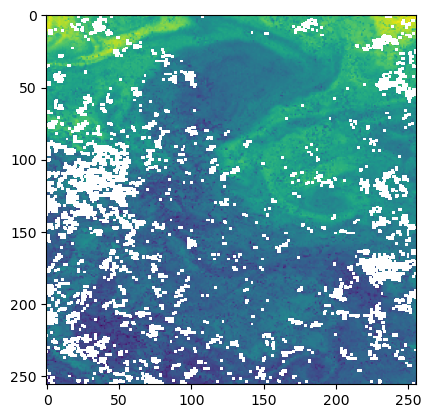

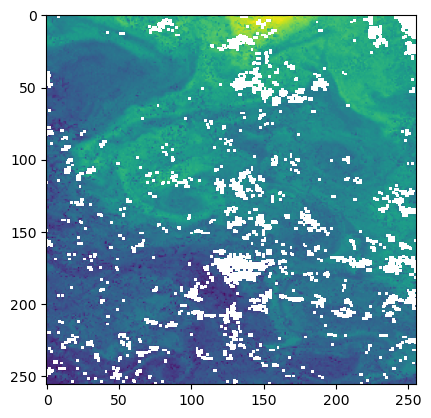

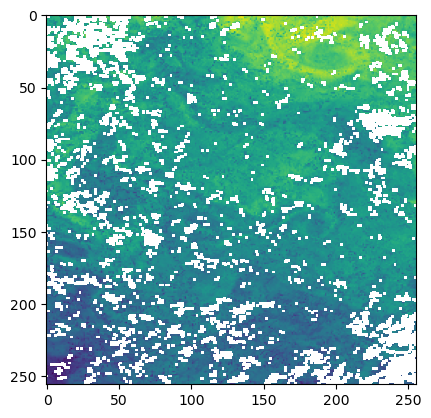

In [265]:
for img in test_slices:
    #print(img.mean())   
    plt.imshow(img)
    plt.show()

In [ ]:
# TODO: how to retain lat/lon information for each candidate image? 
#       need to ensure consistent geographic area over time for training
#       add another return to the method: list of indices for valid slices
# TODO: can this be done in the MFDataset directly?

# Reduce image size 

In [27]:
# FIXME: doesn't seem to be indexing correctly

def slice_images_by_geo(img, latmin, latmax, lonmin, lonmax, 
                        var="sea_surface_temperature", end_shape=(256, 256)):
    
    lat, lon = img.variables['lat'][:], img.variables['lon'][:]
    v = img.variables[var][:]
    
    lat_mask = np.where((lat < latmax) & (lat > latmin), True, False)
    lon_mask = np.where((lon < lonmax) & (lon > lonmin), True, False)
    
    var_slice = []
    
    for m in range(len(v)):
        var_slice.append(v[m,][lat_mask,:][:,lon_mask]) # FIXME: here

    return np.ma.masked_array(var_slice)

In [28]:
test_slice = slice_images_by_geo(test["sst_2021-06"], latmin=45, latmax=50.5, lonmin=-20.5, lonmax=-15)
print(test_slice.shape)

(30, 275, 275)


In [31]:
print(test_slice.min())
print(test_slice.max())
print(test_slice.mean())

-32768.0
291.44
-23313.600586212684


In [77]:
test_slice[:,][:256,:256].shape #[:,:256].shape # 30x256x256

(30, 256, 275)

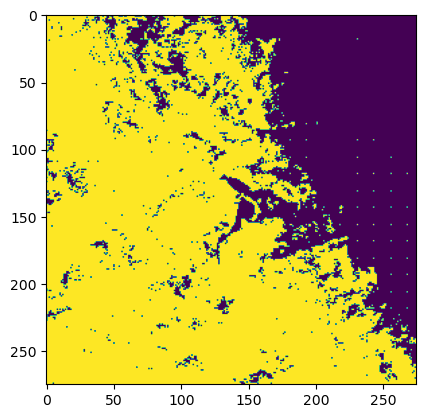

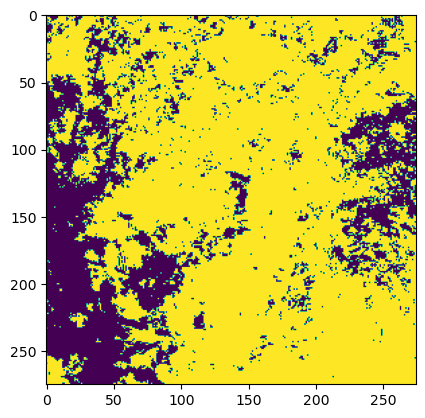

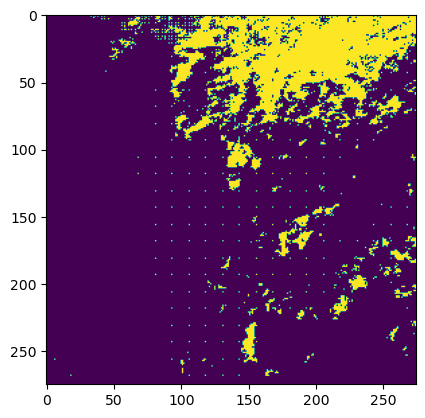

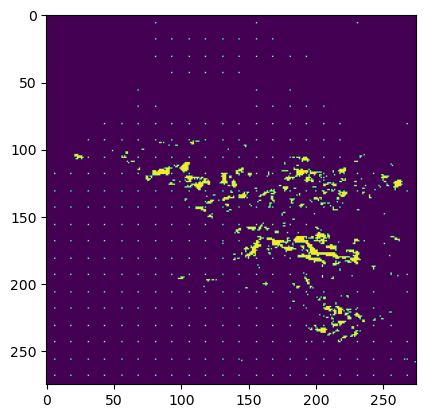

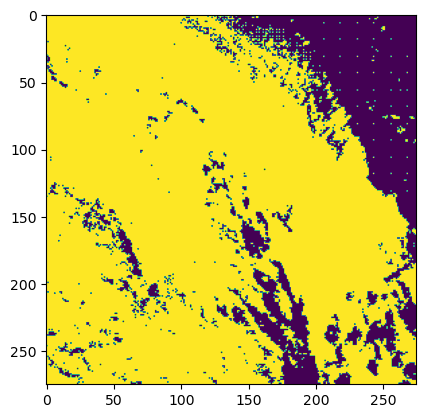

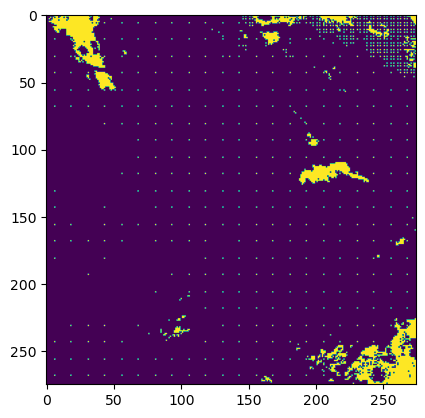

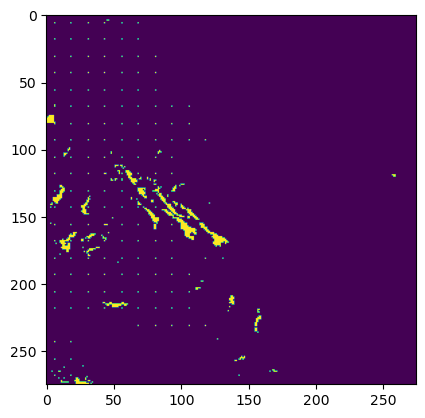

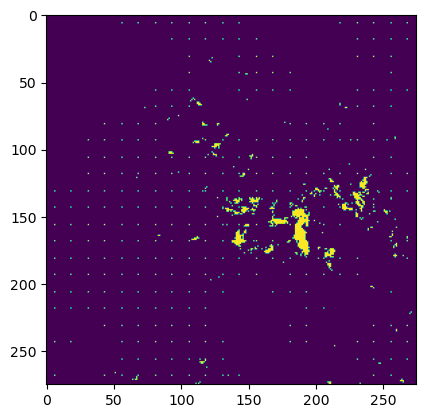

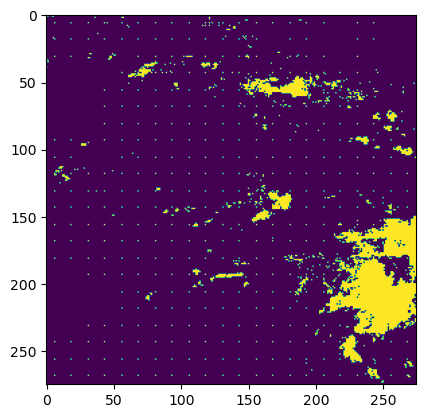

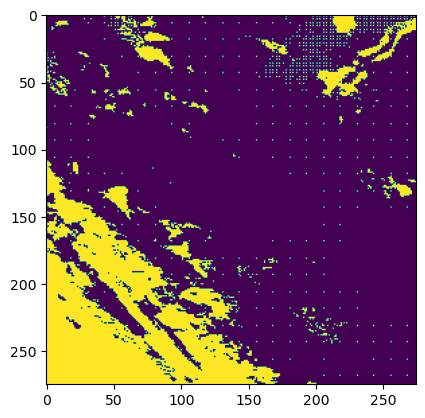

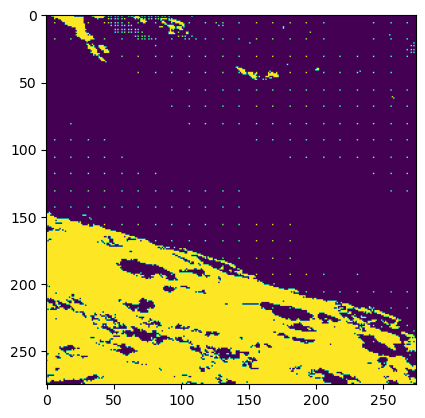

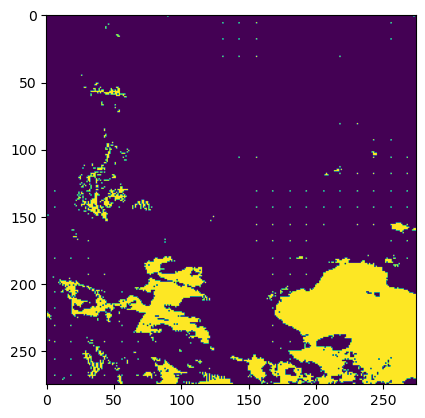

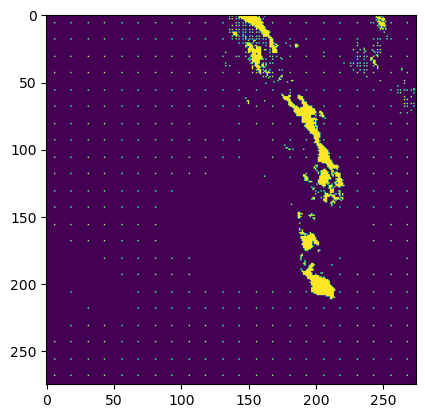

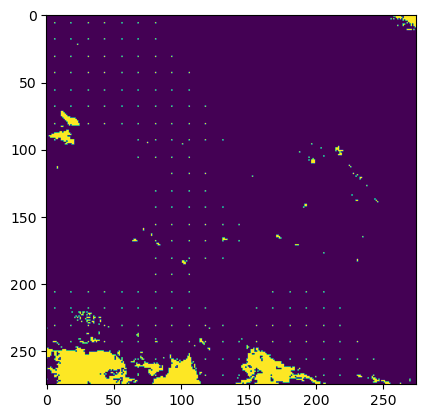

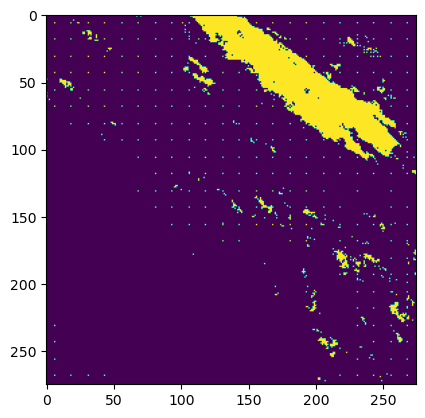

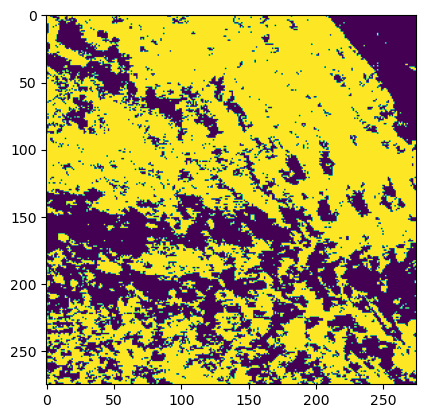

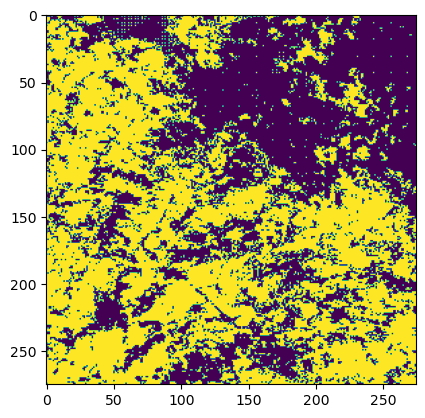

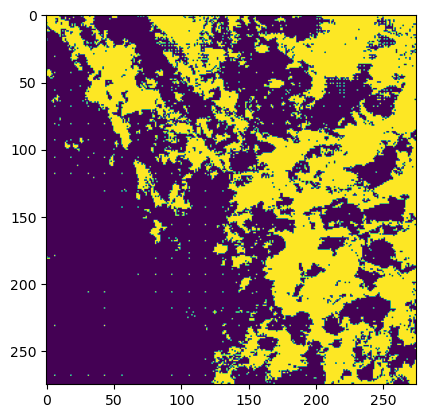

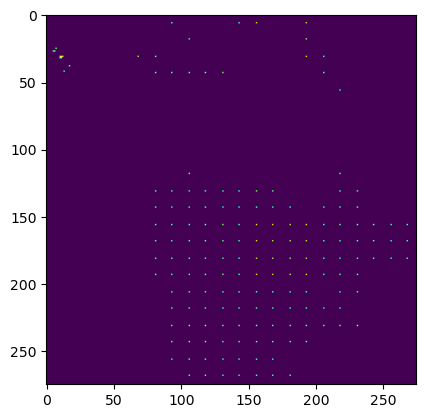

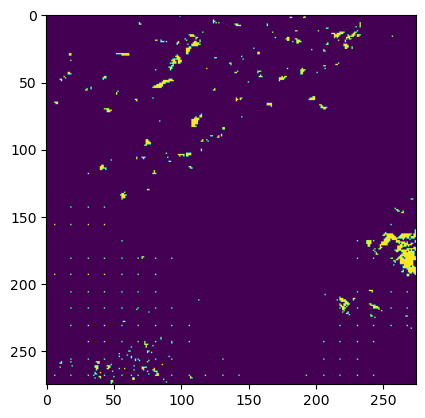

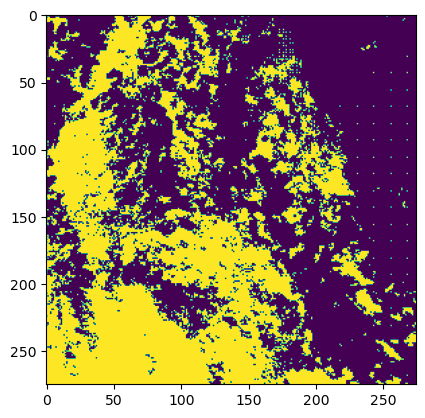

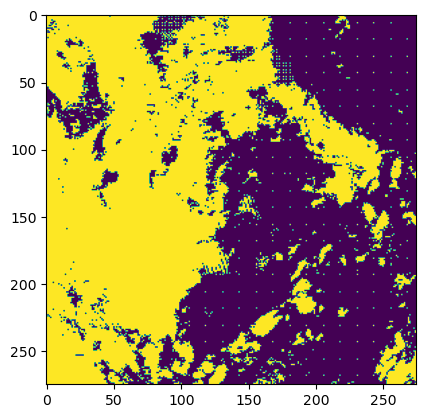

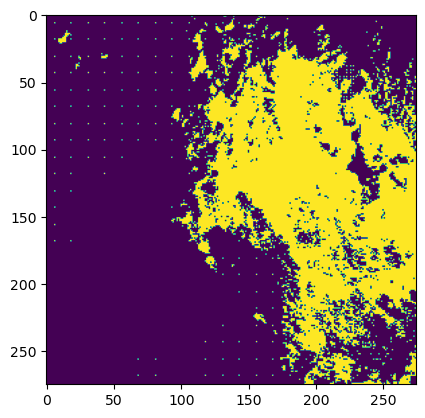

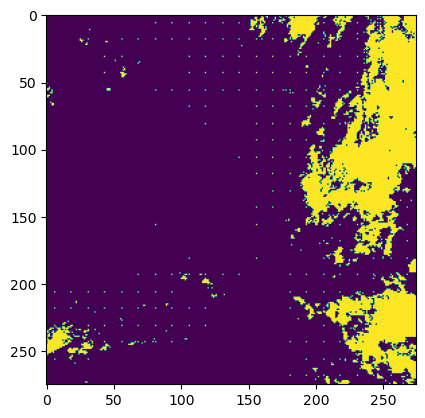

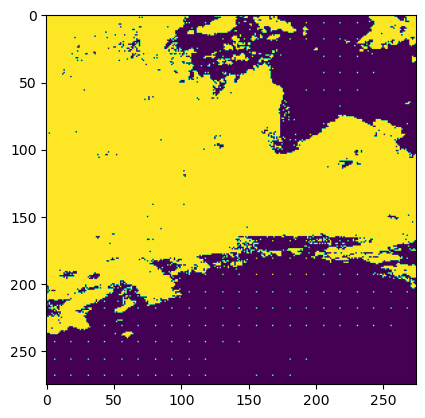

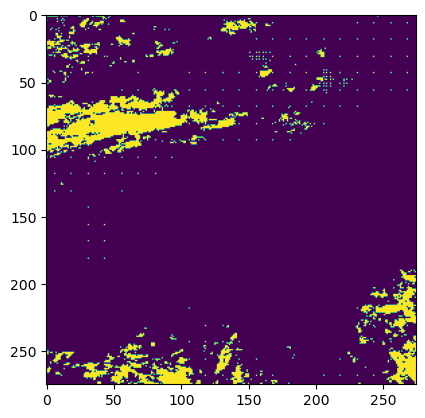

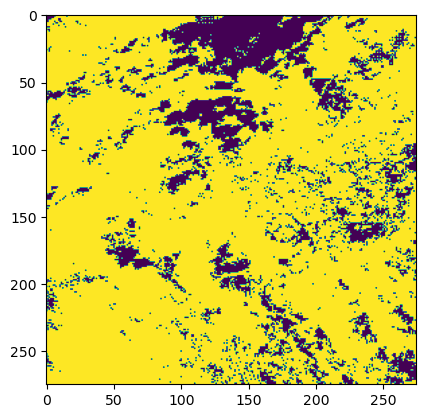

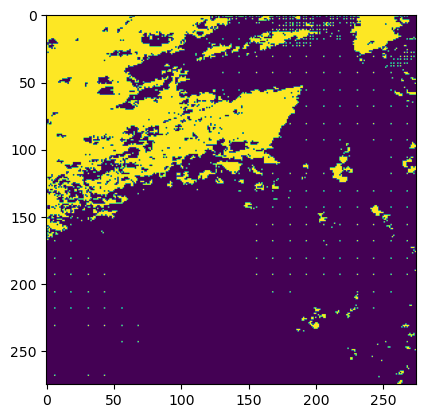

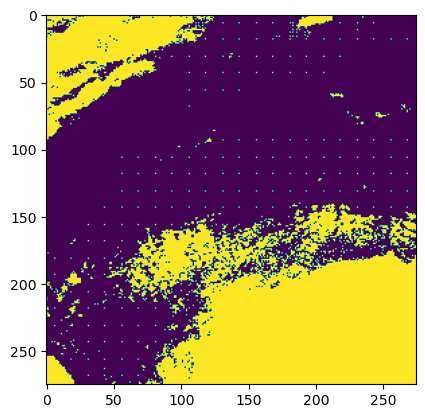

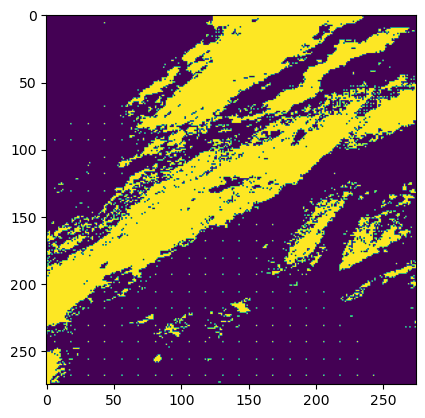

In [30]:
#june1 = sst[0,] # the snapshot of the first of June 
#plt.imshow(june1)

for i in range(len(test_slice)):
    plt.imshow(test_slice[i,])
    plt.show()

In [ ]:
# TODOs:
# 1. Investigate why some values were masked - missing data? incorrect measurements?
# 2. Load extracted numeric values into PyTorch Dataset
#    Link: https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
# 3. Clean up imports
# 4. Convert units from K to degrees C

https://www.youtube.com/@climateunboxed/videos

https://www.earthinversion.com/utilities/reading-NetCDF4-data-in-python/

https://stackoverflow.com/questions/36360469/read-nc-netcdf-files-using-python

https://unidata.github.io/netcdf4-python/#creatingopeningclosing-a-netcdf-file

https://marine.copernicus.eu/user-corner/user-notification-service/gh-416-technical-issue-impacting-new

https://www.earthdatascience.org/courses/use-data-open-source-python/hierarchical-data-formats-hdf/use-netcdf-in-python-xarray/

https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html

https://stackoverflow.com/questions/35422862/speeding-up-reading-of-very-large-netcdf-file-in-python

https://numpy.org/doc/stable/reference/maskedarray.html

Data sources:
1. https://data.marine.copernicus.eu/product/SST_ATL_PHY_L3S_NRT_010_037/description
2. https://help.marine.copernicus.eu/en/articles/4521873-how-to-download-a-dataset-from-ftp-server
4. https://catalogue.marine.copernicus.eu/documents/PUM/CMEMS-SST-PUM-010-037.pdf